In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from zipfile import ZipFile
file_name='/content/drive/My Drive/steel-defect-detection.zip'
with ZipFile(file_name,'r') as Zip:
  Zip.extractall()

In [ ]:
!pip install --upgrade jax jaxlib
!pip install tensorflow==2.15.0
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
      Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
 

In [ ]:
import tensorflow as tf
import keras
from PIL import Image
import os
import numpy as np
import tensorflow_addons as tfa
from tqdm import tqdm
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
def recall_m(y_true, y_pred):
    print(K.clip(y_true * y_pred, 0, 1))
    print(K.round(K.clip(y_true * y_pred, 0, 1)))
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def path2image(path):
  image_string = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image_string, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [299,299])
  image=tf.expand_dims(image,0)
  return image

In [ ]:
def seg_pred(path):
    image_string = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float16)
    image = tf.image.resize(image, [256,800])
    image = tf.image.convert_image_dtype(image, tf.uint8)
    image=tf.expand_dims(image,0)
    return image

In [ ]:
dependencies = {
    'precision_m': precision_m,
    'recall_m':recall_m,
    'f1_m':f1_m}

#weights for binary classification

po='/content/drive/My Drive/binary_model/weights-21-0.9535.hdf5'
binary_model=tf.keras.models.load_model(filepath=po, custom_objects=dependencies, compile=True)

In [ ]:
#weights for multilabel classification

po='/content/drive/My Drive/multi_lab_model/weights-11-0.9236.hdf5'
multilabel_model=tf.keras.models.load_model(filepath=po, compile=True)

In [ ]:
#weights for segmentation defect 1

po='/content/drive/My Drive/defect1_seg_model_b8_e20/weights_19.hdf5'
defect1_model = tf.keras.models.load_model(filepath=po)

In [ ]:
#weights for segmentation defect 2

po='/content/drive/My Drive/defect2_seg_model/weights_18.hdf5'
defect2_model=tf.keras.models.load_model(filepath=po)

In [ ]:
#weights for segmentation defect 3

po='/content/drive/My Drive/defect3_seg_model_b6_e15/weights_14.hdf5'
defect3_model=tf.keras.models.load_model(filepath=po)

In [ ]:
#weights for segmentation defect 4

po='/content/drive/My Drive/defect4_seg_model/weights_7.hdf5'
defect4_model=tf.keras.models.load_model(filepath=po)

In [ ]:
# RLE to Mask

def rle2mask(mask_rle, shape=(1600,256)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1])
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape).T

In [ ]:
def mask2rle(img):
    pixels= img.T.flatten()

    #Adds a 0 at the start and end of the pixels array. This is done to ensure that any run of 1s at the beginning or end of the mask is correctly captured.
    pixels = np.concatenate([[0], pixels, [0]])

    #Identifies where the values in pixels change from 0 to 1 or 1 to 0. This is where a run begins or ends.
    #np.where(pixels[1:] != pixels[:-1]) returns the indices where the change occurs.
    #Adding 1 shifts the index to represent the start of the run (since indices in pixels start at 0).
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1

    #runs[::2] contains the start positions of the runs, and runs[1::2] initially contains the end positions.
    #Subtracting the start positions from the end positions gives the lengths of the runs.
    runs[1::2] -= runs[::2]

    #Converts the runs into a space-separated string, which is the RLE format.
    return ' '.join(str(x) for x in runs)


#The sum_enc function calculates the total number of pixels represented by the runs in an RLE string.
#For the RLE string "3 2 7 3 13 2", the sum_enc function would calculate:
# 2 + 3 + 2 = 7
# This means that 7 pixels in total are part of the object/defect in the mask.

def sum_enc(i):
    return sum([int(k) for k in i.split(' ')[1::2]])


# mask2rle converts a binary mask into an RLE string, which is a compact representation of where the 1s (object/defect pixels) are located in the mask.
# sum_enc calculates the total number of 1 pixels in the mask by summing the lengths in the RLE string. This is useful for quickly assessing how much of the image is occupied by the object/defect.


In [ ]:
# combine_mask creates a 3D binary mask array where each slice (along the third dimension) represents a mask for a different class or label.
# This is useful for multi-class or multi-label segmentation tasks.


def combine_mask(rles):
# d represents the number of RLE strings in the list rles. Each RLE string corresponds to a mask for one specific class/label.
# Example: If rles has 4 elements, then d = 4.
    d = len(rles)
    h, w = 256,1600
    mask = np.zeros((h, w, d))

    for i, rle in enumerate(rles):
        if type(rle) is str:
            mask[:, :, i] = rle2mask(rle, (w, h))
#  mask[:, :, i] represents the i-th layer of the 3D mask array. This layer is filled with the binary mask corresponding to the i-th RLE string.
# Example: For the first RLE string, the 2D mask generated by rle2mask will be placed in mask[:, :, 0].

    return mask

In [ ]:
def mask_predict(location):
  output=[]
  po=os.listdir('test_images')
  for u in tqdm(np.random.randint(0,len(po),10)):
    i=po[u]
    path='test_images/'+i
    img=path2image(path)

    binary_model_pred = binary_model(img)[0][0]
    if binary_model_pred >= 0.4:
      multilabel_model_pred = multilabel_model(img)[0]
      seg_img = seg_pred(path)

      if multilabel_model_pred[0] >= 0.4:
        #The mask is converted to RLE format using mask2rle.
        defect1_model_pred = mask2rle(np.array(tf.cast(tf.image.resize(defect1_model(seg_img),(256,1600)),np.uint8)[0,:,:,0]))
        #The total number of defect pixels (s1) is calculated using sum_enc.
        s1 = sum_enc(defect1_model_pred)
        #The RLE string is added to the output list if s1 falls within a specified range (450 to 17,983 pixels).
        if s1 >= 450 and s1 <= 17983:
          output.append([i+'_1',defect1_model_pred])
      #If the probability is below 0.8, an empty string is added for defect 1.
      else:
        output.append([i+'_1',''])

      if multilabel_model_pred[1] >= 0.8:
        defect2_model_pred = mask2rle(np.array(tf.cast(tf.image.resize(defect2_model(seg_img),(256,1600)),np.uint8)[0,:,:,0]))
        s2 = sum_enc(defect2_model_pred)
        if s2 >= 700 and s2 <= 9200:
          output.append([i+'_2',defect2_model_pred])
      else:
        output.append([i+'_2',''])

      if multilabel_model_pred[2] >= 0.35:
        defect3_model_pred = mask2rle(np.array(tf.cast(tf.image.resize(defect3_model(seg_img),(256,1600)),np.uint8)[0,:,:,0]))
        s3 = sum_enc(defect3_model_pred)
        if s3 >= 900 and s3 <= 162877:
          output.append([i+'_3',defect3_model_pred])
      else:
        output.append([i+'_3',''])

      if multilabel_model_pred[3] >= 0.4:
        defect4_model_pred = mask2rle(np.array(tf.cast(tf.image.resize(defect4_model(seg_img),(256,1600)),np.uint8)[0,:,:,0]))
        s4 = sum_enc(defect4_model_pred)
        if s4 >= 2200 and s4 <= 1280000:
          output.append([i+'_4',defect4_model_pred])
      else:
        output.append([i+'_4',''])

    #If No Defects Detected by Binary Model
    else:
      output.append([i+'_1',''])
      output.append([i+'_2',''])
      output.append([i+'_3',''])
      output.append([i+'_4',''])
  f = pd.DataFrame(output,columns=['ImageId_ClassId','EncodedPixels'])

  return f

In [ ]:
out = mask_predict('test_images')

100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


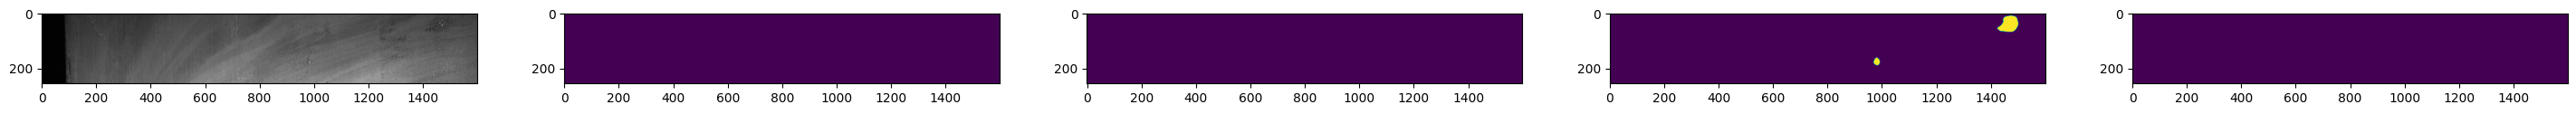

Prediction : Steel has type 3 defect
******************************************************************************************************************************************************************** 



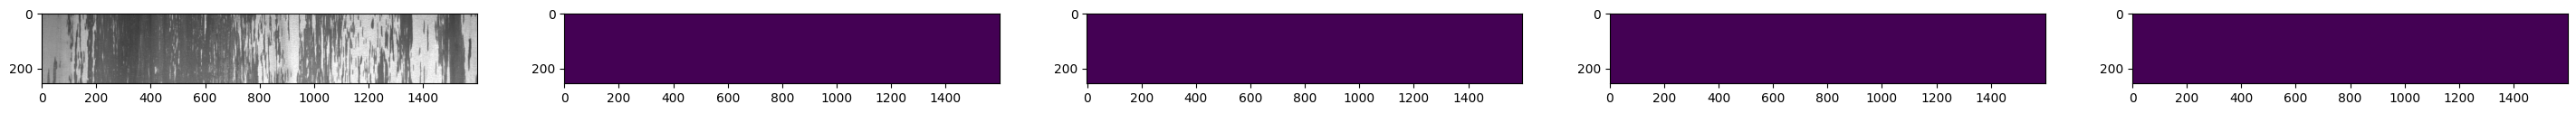

Prediction : Steel has no defect defect
******************************************************************************************************************************************************************** 



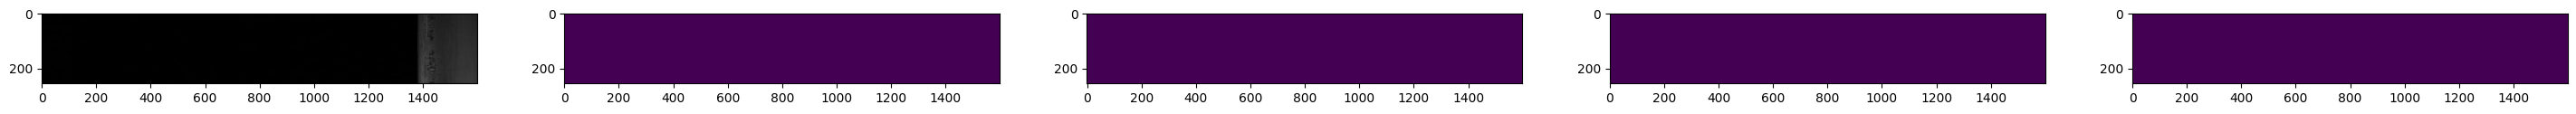

Prediction : Steel has no defect defect
******************************************************************************************************************************************************************** 



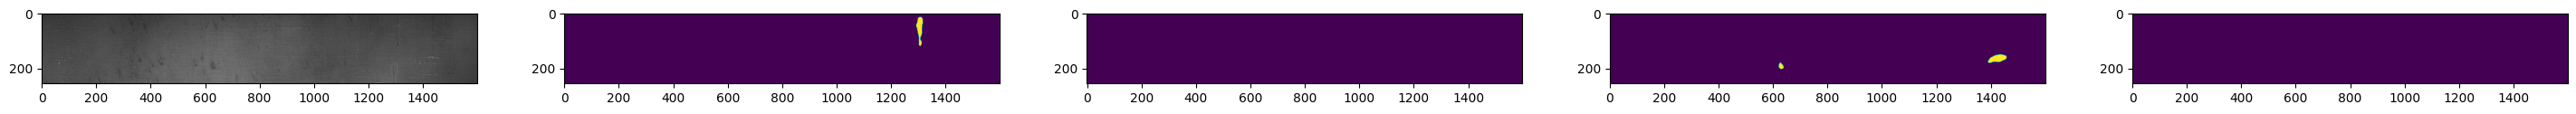

Prediction : Steel has type 1 defect
Prediction : Steel has type 3 defect
******************************************************************************************************************************************************************** 



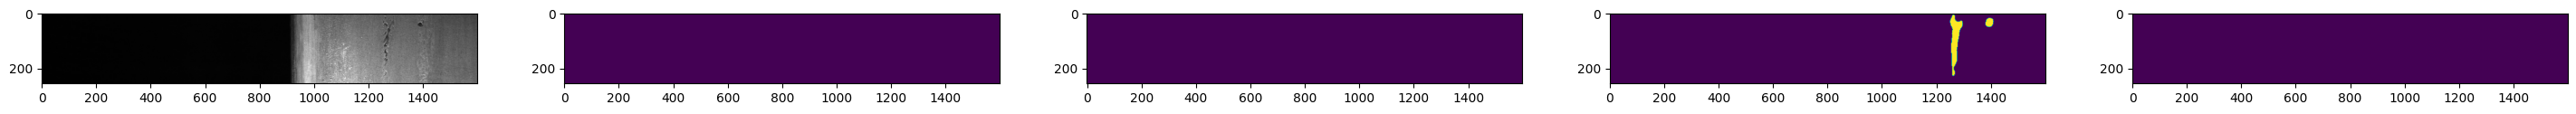

Prediction : Steel has type 3 defect
******************************************************************************************************************************************************************** 



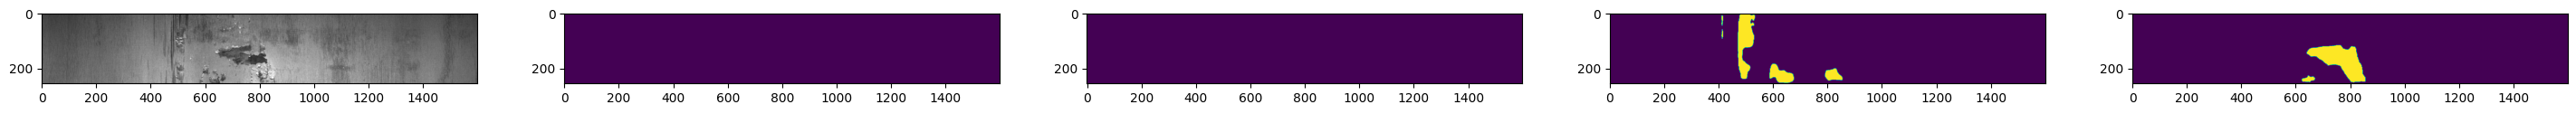

Prediction : Steel has type 3 defect
Prediction : Steel has type 4 defect
******************************************************************************************************************************************************************** 



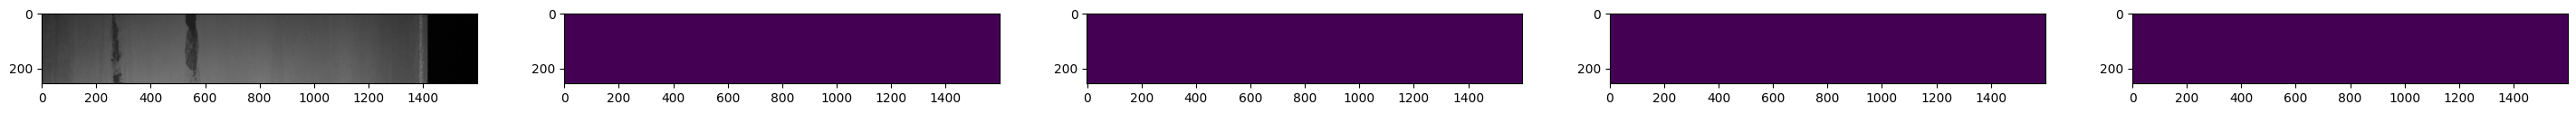

Prediction : Steel has no defect defect
******************************************************************************************************************************************************************** 



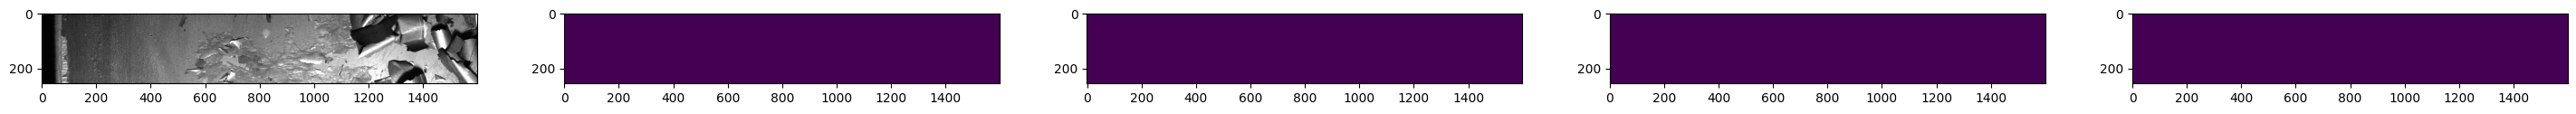

Prediction : Steel has no defect defect
******************************************************************************************************************************************************************** 



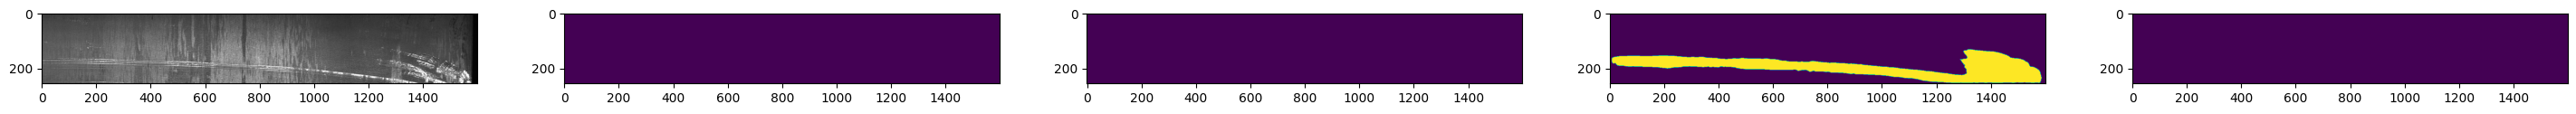

Prediction : Steel has type 3 defect
******************************************************************************************************************************************************************** 



In [ ]:
s=0
e=4
q=out.EncodedPixels.values
p=out.ImageId_ClassId
for i in range(int(len(out)/4)):
      o='test_images/'+p[s].split('_')[0]
      po=q[s:e]
      t=combine_mask(po)
      s=s+4
      e=e+4
      plt.figure(figsize=(36,26))
      plt.subplot(151)
      plt.imshow(plt.imread(o))
      plt.subplot(152)
      plt.imshow(t[:,:,0])
      plt.subplot(153)
      plt.imshow(t[:,:,1])
      plt.subplot(154)
      plt.imshow(t[:,:,2])
      plt.subplot(155)
      plt.imshow(t[:,:,3])
      plt.show()
      w=len(np.where(t[:,:,0]>0)[0])
      if w>0:
        print('Prediction : Steel has type 1 defect')
      x=len(np.where(t[:,:,1]>0)[0])
      if x>0:
        print('Prediction : Steel has type 2 defect')
      y=len(np.where(t[:,:,2]>0)[0])
      if y>0:
        print('Prediction : Steel has type 3 defect')
      z=len(np.where(t[:,:,3]>0)[0])
      if z>0:
        print('Prediction : Steel has type 4 defect')
      if (w+x+y+z)==0:
        print('Prediction : Steel has no defect defect')
      print('**'*82,'\n')